# Classification Representation Demo (Z)

This notebook demonstrates:
1) extracting normalized latent representations **Z** from a trained ArcMol model  
2) visualizing Z with **t-SNE**, **2D spherical map**, and **3D sphere projection**  
for a classification dataset (e.g., `bbb_logbb`).

> All steps are runnable end-to-end.

What is Z?
We extract normalized latent representations Z as:

compute fused representation X = model.encode(...)
apply projection head z_raw = proj(X)
normalize to unit sphere Z = z_raw / ||z_raw||
This corresponds to the implementation in our extraction code (projection + normalization).


In [1]:
import os
import sys

# ============
TASK_NAME = "bbb_logbb"

DATA_DIR = "/home/zyrlia/zou/CMD-/CMD-ADMET/dataset/admet_datasets/bbb_logbb/"  # 你数据目录
BUNDLE_PATH = "bbb_logbb/best_arcmol_arc_reg_RDKFingerprint+MACCSkeys+EStateFingerprint+MolT5+BioT5+AttrMask+GPT-GNN+GraphCL+MolCLR+GraphMVP+GROVER+UniMolV1+UniMolV2_84M+UniMolV2_1.1B_seed42.bundle.pt"  # 改成你的bundle路径（可以写相对路径）
CKPT_PATH   = "bbb_logbb/best_arcmol_arc_reg_RDKFingerprint+MACCSkeys+EStateFingerprint+MolT5+BioT5+AttrMask+GPT-GNN+GraphCL+MolCLR+GraphMVP+GROVER+UniMolV1+UniMolV2_84M+UniMolV2_1.1B_seed42.pth"        # 改成你的ckpt路径

OUT_DIR = "./z_features_output_bbb_logbb_demo"  # 输出目录（notebook当前目录下）
# ==========================

os.makedirs(OUT_DIR, exist_ok=True)
print("OUT_DIR:", os.path.abspath(OUT_DIR))


OUT_DIR: /home/data/zou/CMD-/CMD-ADMET/CMD-ADMET/Few_shot/ARCMOL/z_features_output_bbb_logbb_demo


In [2]:
import sys
import torch


sys.path.append(os.getcwd())

from attention_pooling_fusion import AttentionPoolingFusion
from main_arcmol_mcc_r2 import (
    set_seed,
    filter_data_for_training,
    extract_rdkit_and_target,
    extract_selected_embedding,
    create_loader,
    TaskAwareDescriptorPooling,
    ArcMolModel,
)

print("Imported OK")


Imported OK


In [3]:
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

bundle = torch.load(BUNDLE_PATH, map_location="cpu")
seed = int(bundle.get("seed", 24))
set_seed(seed)

task_type = bundle["task"]["task_type"]
target_name = bundle["task"]["target_name"]
fusion_embed_types = bundle["fusion_embed_types"]

attributes = bundle["rdkit"]["attribute_names"]
topk = bundle["rdkit"]["topk_idx"]
scaler = bundle["rdkit"]["scaler"]

model_hparams = bundle["model_hparams"]

# build modules
in_dim_desc = len(topk)
desc_module = TaskAwareDescriptorPooling(in_dim=in_dim_desc, h=128, out_dim=64, drop=0.1).to(device)

fusion_module = AttentionPoolingFusion(
    used_embedding_types=fusion_embed_types,
    l_output_dim=model_hparams["fusion_out_dim"],
    hidden_dim=model_hparams["fusion_hidden_dim"],
    dropout_prob=model_hparams["fusion_dropout"],
    comp_mode=model_hparams["comp_mode"],
    cka_gamma=model_hparams["cka_gamma"],
    task_gate=model_hparams["task_gate"],
    task_ctx_dim=model_hparams["task_ctx_dim"],
    comp_scale=model_hparams["comp_scale"],
    top_k=model_hparams["moe_topk"],
    sparse_lambda=model_hparams["moe_sparse_lambda"],
).to(device)

in_dim = model_hparams["fusion_out_dim"] + 64
num_classes = 2 if task_type == "cls" else 1

model = ArcMolModel(
    fusion_module,
    desc_module,
    in_dim=in_dim,
    task_type=task_type,
    num_classes=num_classes,
    task_ctx_dim=model_hparams["task_ctx_dim"],
    use_task_ctx=bool(model_hparams["use_task_ctx"]),
    margin=model_hparams["margin"],
    scale=model_hparams["scale"],
    head_hidden=model_hparams["head_hidden"],
    head_dropout=model_hparams["head_dropout"],
    proxy_dropout=model_hparams["proxy_dropout"],
    arc_reg_use=bool(model_hparams.get("arc_reg_use", False)),
    arc_reg_nbins=model_hparams.get("arc_reg_nbins", 32),
    arc_reg_margin=model_hparams.get("arc_reg_margin", 0.10),
    arc_reg_scale=model_hparams.get("arc_reg_scale", 16.0),
    arc_reg_soft_sigma=model_hparams.get("arc_reg_soft_sigma", 0.0),
).to(device)

state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state, strict=True)
model.eval()

print("Model loaded. task_type =", task_type, "| embed_types =", len(fusion_embed_types))


device: cuda


/home/data/zou/Manba/Mamba/envs/cmd_admet/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model loaded. task_type = cls | embed_types = 14


In [4]:
import torch.nn.functional as F

@torch.no_grad()
def extract_features_epoch_Z(model, loader, device, task_type="cls"):
    model.eval()

    # locate proj head
    proj_module = None
    if task_type == "cls" and hasattr(model, "student") and hasattr(model.student, "proj"):
        proj_module = model.student.proj
    elif task_type == "reg" and hasattr(model, "arc_reg") and model.arc_reg is not None and hasattr(model.arc_reg, "proj"):
        proj_module = model.arc_reg.proj

    if proj_module is None:
        raise RuntimeError(f"Cannot find proj head for Z extraction (task_type={task_type}).")

    Z_list, Y_list = [], []

    for (emb_dict, d), y in loader:
        emb_dict = {k: v.to(device) for k, v in emb_dict.items()}
        d = d.to(device)
        y = y.to(device)

        # 1) fused representation x
        x, _ = model.encode(emb_dict, d)

        # 2) projection + normalize
        z_raw = proj_module(x)
        z = F.normalize(z_raw, dim=-1)

        Z_list.append(z.detach().cpu().numpy())
        Y_list.append(y.detach().cpu().numpy())

    Z = np.concatenate(Z_list, axis=0)
    Y = np.concatenate(Y_list, axis=0)
    return Z, Y


In [5]:
import pickle

def load_split_raw(data_dir, task_name, split):
    p = os.path.join(data_dir, f"{task_name}_{split}.pkl")
    if not os.path.exists(p):
        raise FileNotFoundError(p)
    with open(p, "rb") as f:
        return pickle.load(f)

def process_split_and_save(split_name: str):
    raw_data = load_split_raw(DATA_DIR, TASK_NAME, split_name)

    # 1) filter
    filtered = filter_data_for_training(raw_data, fusion_embed_types, target=target_name)
    print(f"[{split_name}] after filter:", len(filtered))
    if len(filtered) == 0:
        raise RuntimeError(f"No valid samples in {split_name}")

    # 2) rdkit desc
    X, y_raw = extract_rdkit_and_target(filtered, attributes, target=target_name, task_type=task_type)
    X_sel = X[:, topk]
    X_sel = scaler.transform(X_sel)
    desc = torch.tensor(X_sel, dtype=torch.float32)

    # 3) embeddings + y for loader
    emb, y_for_loader = extract_selected_embedding(filtered, fusion_embed_types, target=target_name, task_type=task_type)

    # 4) loader
    loader = create_loader(emb, desc, y_for_loader, bs=128, shuffle=False)

    # 5) extract Z
    Z, _Y_dummy = extract_features_epoch_Z(model, loader, device, task_type=task_type)

    # 6) save (keep original y_raw)
    out_path = os.path.join(OUT_DIR, f"{TASK_NAME}_{split_name}_z_features.pkl")
    with open(out_path, "wb") as f:
        pickle.dump({"features": Z, "y_true": y_raw}, f)

    print(f"Saved: {out_path} | Z shape={Z.shape}")
    return out_path

train_pkl = process_split_and_save("train")
test_pkl  = process_split_and_save("test")


[train] after filter: 2562
Saved: ./z_features_output_bbb_logbb_demo/bbb_logbb_train_z_features.pkl | Z shape=(2562, 192)
[test] after filter: 320
Saved: ./z_features_output_bbb_logbb_demo/bbb_logbb_test_z_features.pkl | Z shape=(320, 192)


In [6]:
import numpy as np

def check_pkl(path):
    with open(path, "rb") as f:
        d = pickle.load(f)
    Z = d["features"]
    y = np.squeeze(d["y_true"]).astype(int)
    print(os.path.basename(path), "Z:", Z.shape, "labels:", np.bincount(y))
    print("  mean ||Z|| =", np.linalg.norm(Z, axis=1).mean())

check_pkl(train_pkl)
check_pkl(test_pkl)


bbb_logbb_train_z_features.pkl Z: (2562, 192) labels: [ 612 1950]
  mean ||Z|| = 1.0
bbb_logbb_test_z_features.pkl Z: (320, 192) labels: [ 78 242]
  mean ||Z|| = 1.0


In [7]:
import shutil

shutil.copyfile(train_pkl, f"{TASK_NAME}_train_z_features.pkl")
shutil.copyfile(test_pkl,  f"{TASK_NAME}_test_z_features.pkl")
print("Prepared plot inputs in cwd.")


Prepared plot inputs in cwd.


## Quantitative sanity checks (clustering metrics)

Before visualizing, we compute two standard clustering metrics on Z:
- **Silhouette Score** (higher is better)
- **Davies–Bouldin Index** (lower is better)

These metrics provide a quick quantitative sanity check that the learned latent space
captures class structure.


In [8]:
from matplotlib.lines import Line2D
from IPython.display import Image, display


COLORS = {
    0: "#009E73",  # Teal
    1: "#CC79A7",  # Pink
}

def make_legend_elements(marker_train="o", marker_test="d",
                         edge_test="#8B8B8B", lw_test=0.8,
                         alpha_train=0.35):
    """
    - Class 0 / Class 1
    - Train / Test
    """
    return [
        # 类别
        Line2D([0], [0], marker='o', color='w', label='Class 0 (Inactive)',
               markerfacecolor=COLORS[0], markersize=9),
        Line2D([0], [0], marker='o', color='w', label='Class 1 (Active)',
               markerfacecolor=COLORS[1], markersize=9),

        # 空行间隔
        Line2D([0], [0], color='w', label='', markersize=0),

        # 数据集 split
        Line2D([0], [0], marker=marker_train, color='w', label='Train Set',
               markerfacecolor='#888888', markersize=9, alpha=alpha_train),
        Line2D([0], [0], marker=marker_test, color='w', label='Test Set',
               markerfacecolor='#888888', markersize=10,
               markeredgecolor=edge_test, markeredgewidth=lw_test),
    ]

def show_image(path, width=520):

    display(Image(filename=path, width=width))


In [9]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import pickle
import os

FILE_PATHS = {
    "train": f"{TASK_NAME}_train_z_features.pkl",
    "test":  f"{TASK_NAME}_test_z_features.pkl",
}

def load_and_evaluate(name, path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    features = data["features"]
    labels = np.squeeze(data["y_true"]).astype(int)

    sil = silhouette_score(features, labels)
    db  = davies_bouldin_score(features, labels)

    return {
        "Dataset": name,
        "Silhouette Score": round(float(sil), 4),
        "Davies-Bouldin Index": round(float(db), 4),
    }

df_metrics = pd.DataFrame([
    load_and_evaluate("TRAIN", FILE_PATHS["train"]),
    load_and_evaluate("TEST",  FILE_PATHS["test"]),
])
df_metrics


,Dataset,Silhouette Score,Davies-Bouldin Index
0,TRAIN,0.8468,0.2336
1,TEST,0.7636,0.3815


## t-SNE visualization of Z (with legend)

We visualize the normalized latent representations **Z** using t-SNE.

- Train samples are shown as semi-transparent background.
- Test samples are highlighted with diamond markers.
- Colors indicate class labels (Class 0 / Class 1).



In [10]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# plt.rcParams.update({"font.family": "Arial", "axes.unicode_minus": False})

# 你原来的参数稍微调小（更合适）
TSNE_CFG = {
    "marker_train": "o",
    "s_train": 26,          
    "alpha_train": 0.28,    
    "marker_test": "d",
    "s_test": 36,           
    "alpha_test": 0.85,
    "edge_test": "#8B8B8B",
    "linewidth_test": 0.7,
    "figsize": (5.2, 4.3), 
    "dpi": 300,
}

def axis_off(ax):
    ax.set_xticks([]); ax.set_yticks([])
    for sp in ["top", "right", "left", "bottom"]:
        ax.spines[sp].set_visible(False)

def load_tsne_data(file_paths):
    all_features, all_labels, all_splits = [], [], []
    for split, path in file_paths.items():
        with open(path, "rb") as f:
            d = pickle.load(f)
        feat = d["features"]
        lab  = np.squeeze(d["y_true"]).astype(int)
        all_features.append(feat)
        all_labels.append(lab)
        all_splits.extend([split] * len(lab))
    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)
    splits = np.array(all_splits)
    return X, y, splits

X, y, splits = load_tsne_data(FILE_PATHS)

tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto")
X_2d = tsne.fit_transform(X)

fig, ax = plt.subplots(figsize=TSNE_CFG["figsize"], dpi=TSNE_CFG["dpi"])

# 分层绘制
mask_train = (splits == "train")
mask_test  = (splits == "test")

for label_val in [0, 1]:
    m = mask_train & (y == label_val)
    if np.any(m):
        ax.scatter(X_2d[m,0], X_2d[m,1],
                   c=COLORS[label_val],
                   marker=TSNE_CFG["marker_train"],
                   s=TSNE_CFG["s_train"],
                   alpha=TSNE_CFG["alpha_train"],
                   edgecolors="none",
                   zorder=1)

for label_val in [0, 1]:
    m = mask_test & (y == label_val)
    if np.any(m):
        ax.scatter(X_2d[m,0], X_2d[m,1],
                   c=COLORS[label_val],
                   marker=TSNE_CFG["marker_test"],
                   s=TSNE_CFG["s_test"],
                   alpha=TSNE_CFG["alpha_test"],
                   edgecolors=TSNE_CFG["edge_test"],
                   linewidth=TSNE_CFG["linewidth_test"],
                   zorder=2)

axis_off(ax)

# ✅ 加 legend（像 2D spherical 一样）
legend_elements = make_legend_elements(
    marker_train=TSNE_CFG["marker_train"],
    marker_test=TSNE_CFG["marker_test"],
    edge_test=TSNE_CFG["edge_test"],
    lw_test=TSNE_CFG["linewidth_test"],
    alpha_train=TSNE_CFG["alpha_train"]
)
ax.legend(handles=legend_elements, frameon=False,
          loc="upper right", bbox_to_anchor=(1.02, 1.02),
          fontsize=9, labelspacing=0.55)

out_tsne = "tsne_classification_with_legend.png"
plt.savefig(out_tsne, bbox_inches="tight")
print("Saved:", out_tsne)


Saved: tsne_classification_with_legend.png


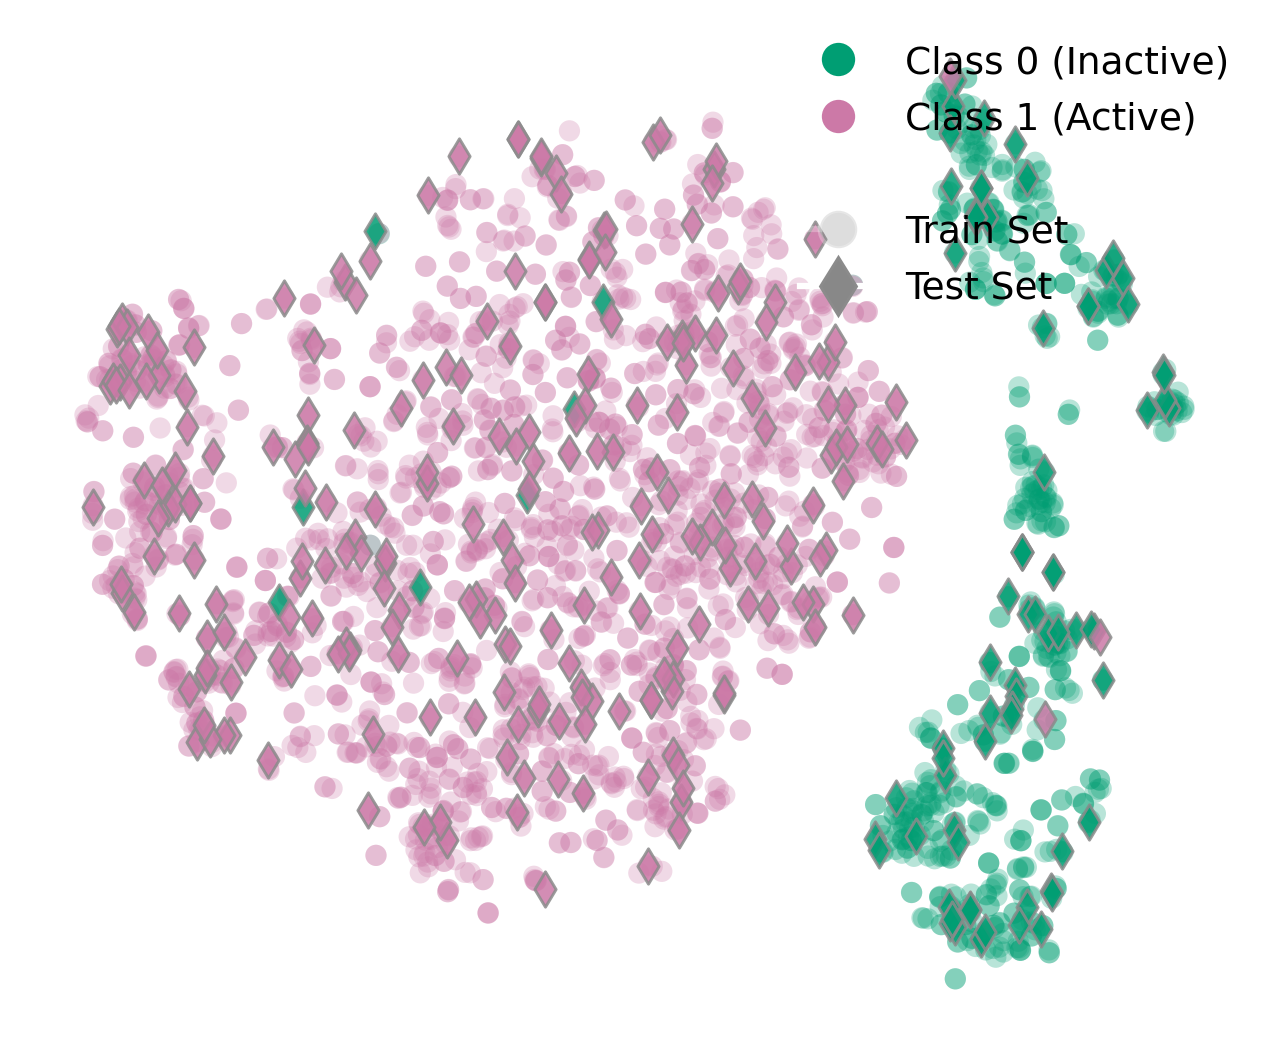

In [11]:
show_image(out_tsne, width=1028)


## 2D spherical projection (with legend)

To further illustrate the unit-sphere structure of Z, we:
1) apply PCA to 3D,
2) normalize to the unit sphere,
3) visualize points using longitude/latitude mapping.


In [12]:
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# plt.rcParams.update({"font.family": "Arial", "axes.unicode_minus": False})

SP2D_CFG = {
    "col_low": "#009E73",
    "col_high": "#CC79A7",
    "marker_train": "o",
    "s_train": 80,
    "alpha_train": 1.0,
    "marker_test": "d",
    "s_test": 80,
    "alpha_test": 1.0,
    "edge_test": "#444444",
    "lw_test": 1.0,
    "figsize": (10, 6),
    "dpi": 300,
}
COLOR_MAP = {0: SP2D_CFG["col_low"], 1: SP2D_CFG["col_high"]}

def normalize_features(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.where(norms == 0, 1e-8, norms)

def load_and_project_data_2d(file_paths):
    all_features_norm, all_labels, all_splits = [], [], []

    for split_name, path in file_paths.items():
        with open(path, "rb") as f:
            d = pickle.load(f)
        feat = d["features"]
        lab  = np.squeeze(d["y_true"]).astype(int)
        feat_z = normalize_features(feat)
        all_features_norm.append(feat_z)
        all_labels.append(lab)
        all_splits.extend([split_name] * len(lab))

    Z_combined = np.concatenate(all_features_norm, axis=0)
    y_combined = np.concatenate(all_labels, axis=0)

    pca = PCA(n_components=3, random_state=42)
    Z_3d = pca.fit_transform(Z_combined)

    norms = np.linalg.norm(Z_3d, axis=1, keepdims=True)
    Z_spherical = Z_3d / np.where(norms == 0, 1e-8, norms)

    Xc, Yc, Zc = Z_spherical[:,0], Z_spherical[:,1], Z_spherical[:,2]
    phi = np.arcsin(np.clip(Zc, -1, 1))     # latitude
    theta = np.arctan2(Yc, Xc)              # longitude

    df = pd.DataFrame({
        "Longitude": np.degrees(theta),
        "Latitude": np.degrees(phi),
        "Label": y_combined,
        "Split": np.array(all_splits),
    })
    return df

def plot_spherical_map_classification(plot_df, output_path="spherical_map_classification.png"):
    fig, ax = plt.subplots(figsize=SP2D_CFG["figsize"], dpi=SP2D_CFG["dpi"])

    for split_type in ["train", "test"]:
        for label_val in [0, 1]:
            mask = (plot_df["Split"] == split_type) & (plot_df["Label"] == label_val)
            sub_df = plot_df[mask]
            if sub_df.empty:
                continue

            if split_type == "train":
                marker = SP2D_CFG["marker_train"]; s = SP2D_CFG["s_train"]; alpha = SP2D_CFG["alpha_train"]
                ec = "none"; lw = 0; zorder = 1
            else:
                marker = SP2D_CFG["marker_test"]; s = SP2D_CFG["s_test"]; alpha = SP2D_CFG["alpha_test"]
                ec = SP2D_CFG["edge_test"]; lw = SP2D_CFG["lw_test"]; zorder = 10

            ax.scatter(
                sub_df["Longitude"], sub_df["Latitude"],
                c=COLOR_MAP[label_val],
                marker=marker, s=s, alpha=alpha,
                edgecolors=ec, linewidth=lw,
                zorder=zorder,
            )

    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xlabel("Longitude", fontsize=12, fontweight="bold")
    ax.set_ylabel("Latitude", fontsize=12, fontweight="bold")
    ax.set_title("Latent Features Spherical Projection", fontsize=16, fontweight="bold", pad=15)
    ax.grid(True, linestyle=":", alpha=0.4, color="gray")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Class 0 (Inactive)',
               markerfacecolor=COLOR_MAP[0], markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Class 1 (Active)',
               markerfacecolor=COLOR_MAP[1], markersize=10),
        Line2D([0], [0], color='w', label='', markersize=0),
        Line2D([0], [0], marker=SP2D_CFG["marker_train"], color='w', label='Train Set',
               markerfacecolor='#888888', markersize=10, alpha=SP2D_CFG["alpha_train"]),
        Line2D([0], [0], marker=SP2D_CFG["marker_test"], color='w', label='Test Set',
               markerfacecolor='#888888', markersize=11,
               markeredgecolor=SP2D_CFG["edge_test"], markeredgewidth=SP2D_CFG["lw_test"]),
    ]
    ax.legend(handles=legend_elements, frameon=False,
              loc="upper right", bbox_to_anchor=(1.0, 1.15),
              fontsize=10, labelspacing=0.6)

    plt.tight_layout()
    plt.savefig(output_path, bbox_inches="tight")
    print("Saved:", output_path)
    return output_path

df2d = load_and_project_data_2d(FILE_PATHS)
out2d = plot_spherical_map_classification(df2d)


Saved: spherical_map_classification.png


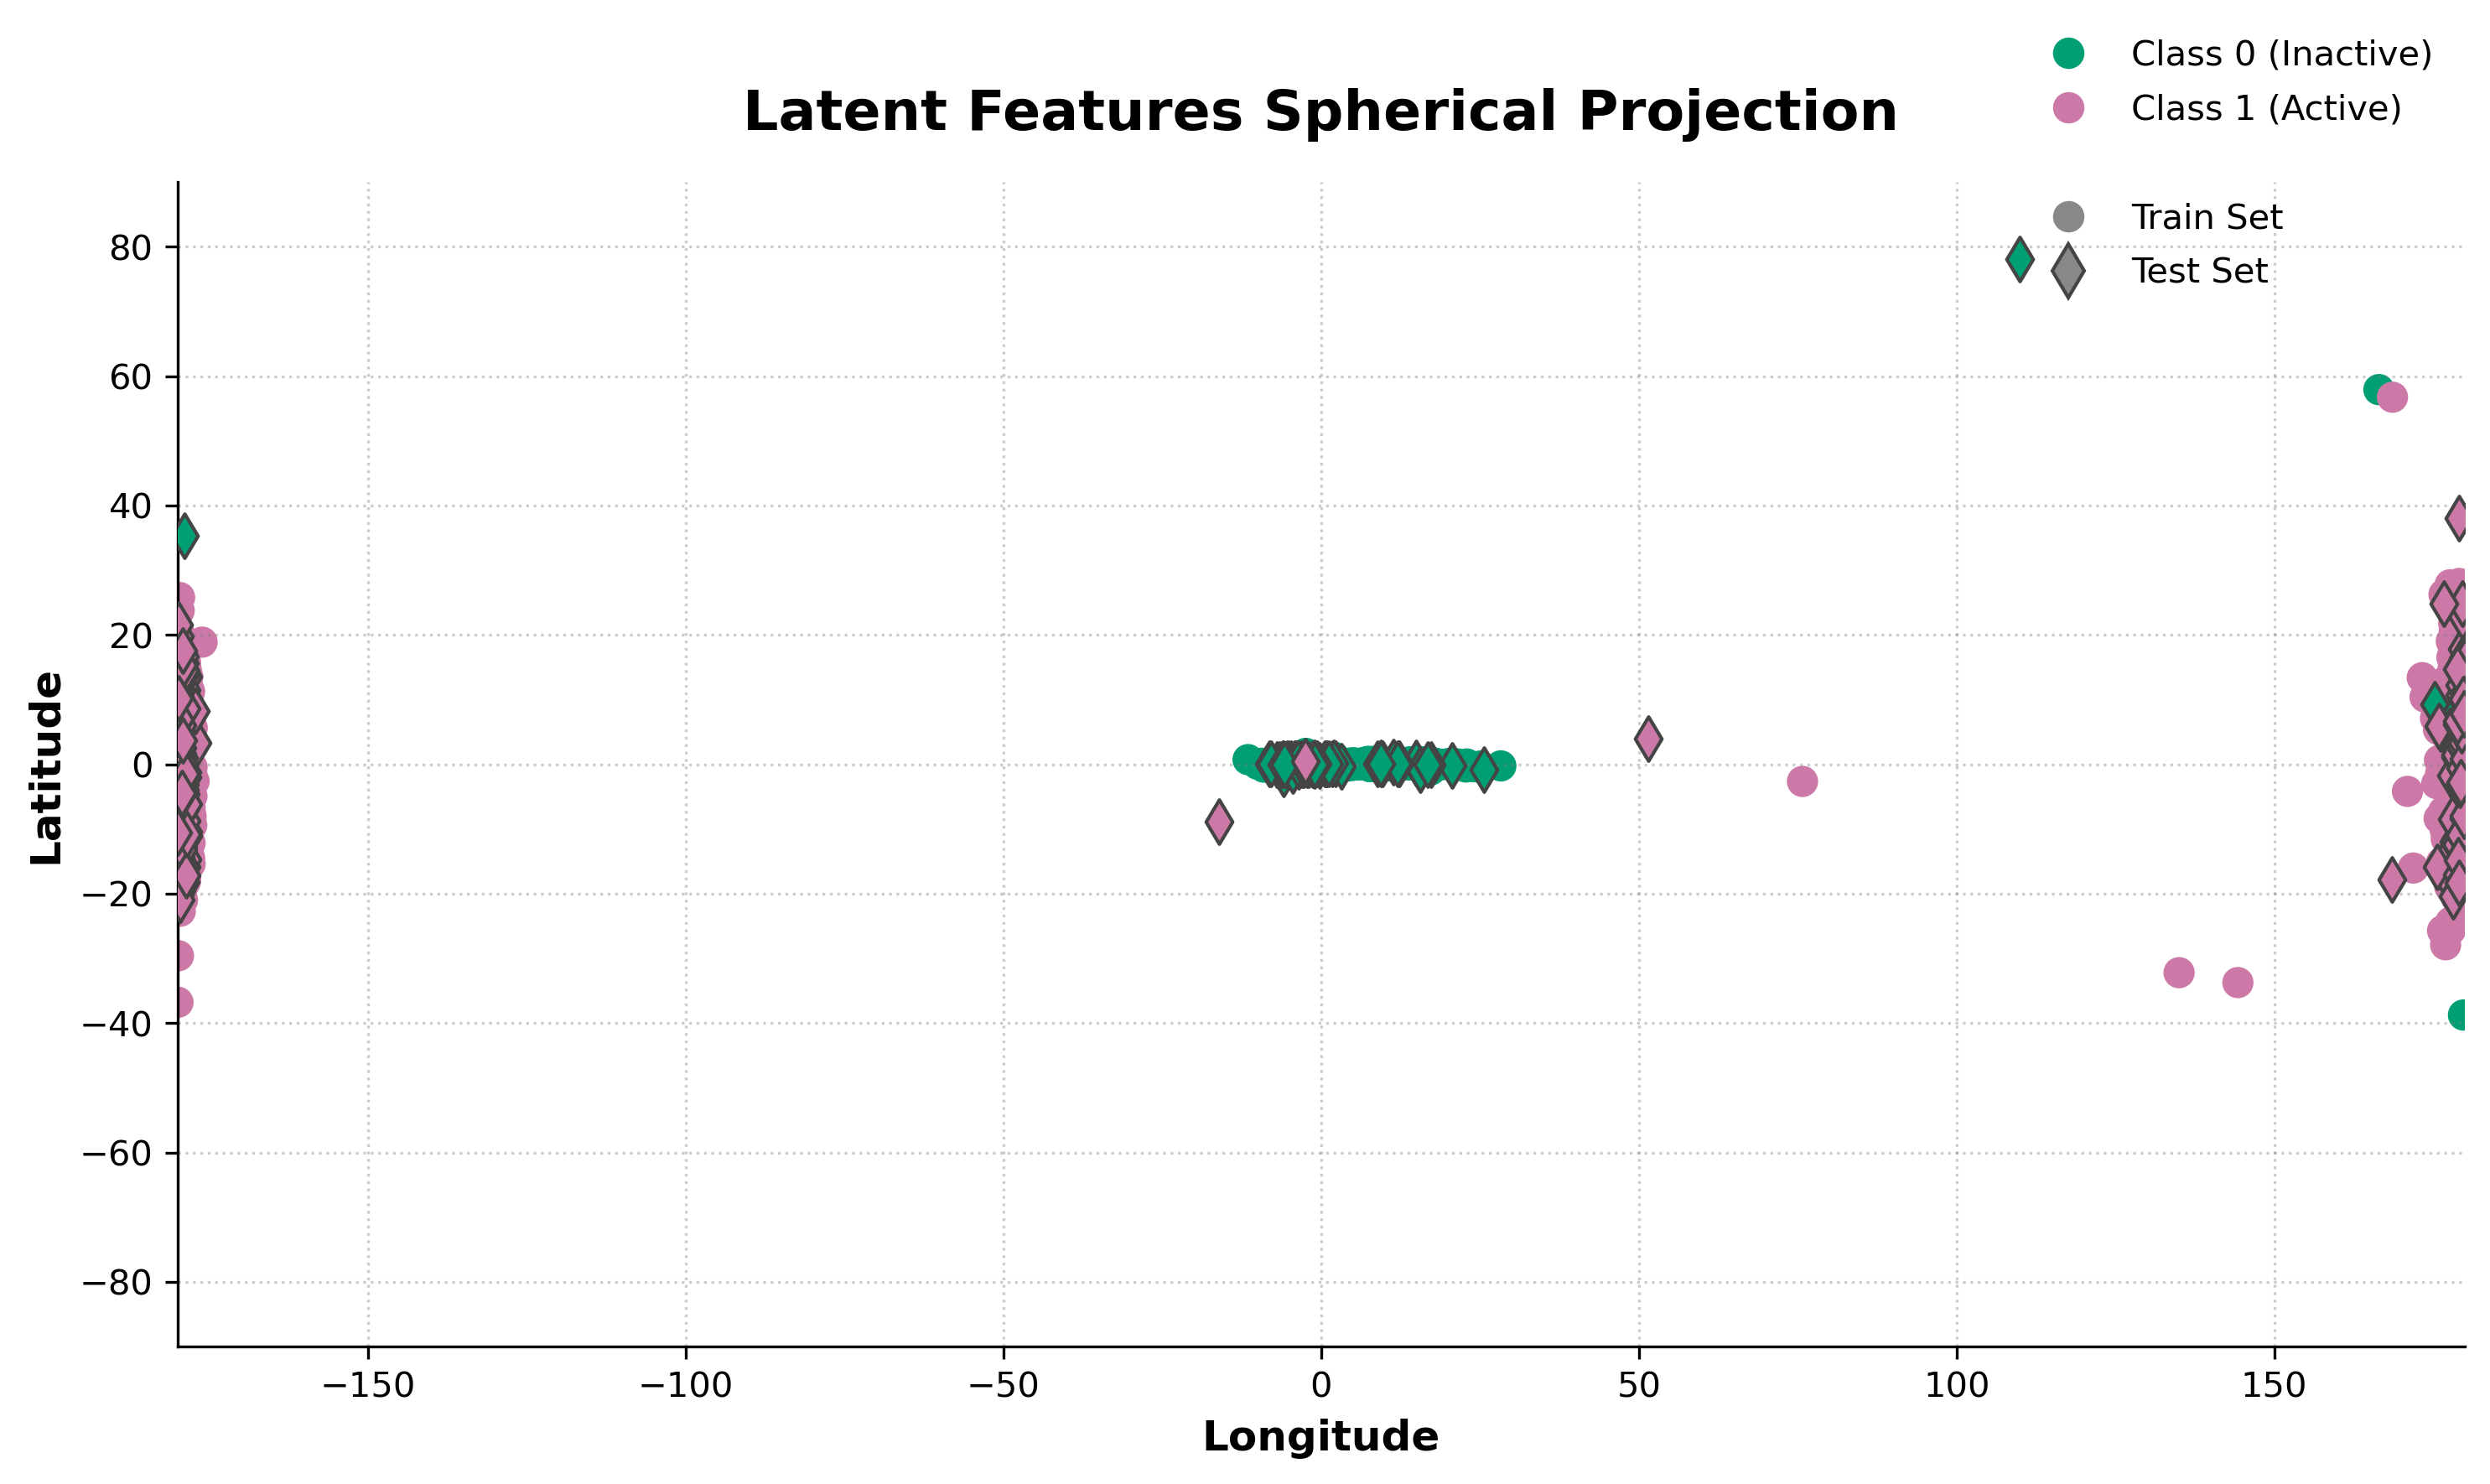

In [13]:
show_image(out2d, width=1028)

## 3D spherical projection (with legend)

We visualize the PCA-reduced Z on a unit sphere in 3D.

- Light wireframe indicates the unit sphere geometry.
- Vector lines (faint) show directions from the origin to each point.
- Test samples are highlighted.


In [14]:
# =========================
# 3D Spherical Projection (Classification) + Full Legend (Class + Split)
# =========================
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# ---- make sure these exist (safe defaults) ----
try:
    TASK_NAME
except NameError:
    TASK_NAME = "bbb_logbb"

FILE_PATHS = {
    "train": f"{TASK_NAME}_train_z_features.pkl",
    "test":  f"{TASK_NAME}_test_z_features.pkl",
}

COLORS = {
    0: "#009E73",  # Teal
    1: "#CC79A7",  # Pink
}

# plt.rcParams.update({"font.family": "Arial", "axes.unicode_minus": False})

SP3D_CFG = {
    "col_low": COLORS[0],
    "col_high": COLORS[1],

    "marker_train": "o",
    "s_train": 55,
    "alpha_train": 0.35,

    "marker_test": "d",
    "s_test": 65,
    "alpha_test": 0.95,
    "edge_test": "#8B8B8B",
    "lw_test": 0.8,

    # 图小一点（适合 notebook）
    "figsize": (6.2, 5.0),
    "dpi": 300,

    # 向量线（太多会慢）
    "max_lines": 2500,
    "line_alpha": 0.12,
    "line_width": 0.5,
}

def _normalize_rows(X: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    n = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.where(n == 0, eps, n)

def load_data_3d(file_paths: dict) -> pd.DataFrame:
    all_features, all_labels, all_splits = [], [], []
    for split, path in file_paths.items():
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing: {path}")

        with open(path, "rb") as f:
            d = pickle.load(f)

        feat = np.asarray(d["features"])
        feat = _normalize_rows(feat)  # ensure on unit sphere
        lab = np.squeeze(d["y_true"]).astype(int)

        all_features.append(feat)
        all_labels.append(lab)
        all_splits.extend([split] * len(lab))

    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)

    # PCA -> 3D -> normalize to unit sphere
    pca = PCA(n_components=3, random_state=42)
    X_3d = pca.fit_transform(X)
    X_3d = _normalize_rows(X_3d)

    df = pd.DataFrame({
        "X": X_3d[:, 0],
        "Y": X_3d[:, 1],
        "Z": X_3d[:, 2],
        "Label": y,
        "Split": np.array(all_splits),
    })
    return df

def make_legend_elements(marker_train="o", marker_test="d",
                         edge_test="#8B8B8B", lw_test=0.8,
                         alpha_train=0.35):
    return [
        Line2D([0], [0], marker='o', color='w', label='Class 0 (Inactive)',
               markerfacecolor=COLORS[0], markersize=9),
        Line2D([0], [0], marker='o', color='w', label='Class 1 (Active)',
               markerfacecolor=COLORS[1], markersize=9),
        Line2D([0], [0], color='w', label='', markersize=0),  # spacer
        Line2D([0], [0], marker=marker_train, color='w', label='Train Set',
               markerfacecolor='#888888', markersize=9, alpha=alpha_train),
        Line2D([0], [0], marker=marker_test, color='w', label='Test Set',
               markerfacecolor='#888888', markersize=10,
               markeredgecolor=edge_test, markeredgewidth=lw_test),
    ]

def plot_3d_sphere_classification(df: pd.DataFrame,
                                  output_path: str = "3d_sphere_classification_lines.png") -> str:
    fig = plt.figure(figsize=SP3D_CFG["figsize"], dpi=SP3D_CFG["dpi"])
    ax = fig.add_subplot(111, projection="3d")

    # --- sphere surface + wireframe ---
    u, v = np.mgrid[0:2*np.pi:55j, 0:np.pi:28j]
    xs = np.cos(u) * np.sin(v)
    ys = np.sin(u) * np.sin(v)
    zs = np.cos(v)

    ax.plot_wireframe(xs, ys, zs, color="#999999", alpha=0.35,
                      linewidth=0.5, rstride=2, cstride=2)
    ax.plot_surface(xs, ys, zs, color="#E0E0E0", alpha=0.03, shade=False)

    # equator (dashed)
    theta = np.linspace(0, 2*np.pi, 200)
    ax.plot(np.cos(theta), np.sin(theta), 0, color="#666666",
            linestyle="--", linewidth=1.0, alpha=0.55)

    # --- vector lines (sample to avoid heavy plotting) ---
    max_lines = SP3D_CFG["max_lines"]
    if len(df) > max_lines:
        df_lines = df.sample(n=max_lines, random_state=42)
    else:
        df_lines = df

    for _, row in df_lines.iterrows():
        line_color = COLORS[int(row["Label"])]
        ax.plot([0, row["X"]], [0, row["Y"]], [0, row["Z"]],
                color=line_color,
                alpha=SP3D_CFG["line_alpha"],
                linewidth=SP3D_CFG["line_width"])

    # --- scatter points: train background, test foreground ---
    for split_type in ["train", "test"]:
        for label_val in [0, 1]:
            m = (df["Split"] == split_type) & (df["Label"] == label_val)
            sub = df[m]
            if sub.empty:
                continue

            if split_type == "train":
                ax.scatter(sub["X"], sub["Y"], sub["Z"],
                           c=COLORS[label_val],
                           marker=SP3D_CFG["marker_train"],
                           s=SP3D_CFG["s_train"],
                           alpha=SP3D_CFG["alpha_train"],
                           edgecolors="none",
                           linewidth=0,
                           zorder=1)
            else:
                ax.scatter(sub["X"], sub["Y"], sub["Z"],
                           c=COLORS[label_val],
                           marker=SP3D_CFG["marker_test"],
                           s=SP3D_CFG["s_test"],
                           alpha=SP3D_CFG["alpha_test"],
                           edgecolors=SP3D_CFG["edge_test"],
                           linewidth=SP3D_CFG["lw_test"],
                           zorder=10)

    # view / aesthetics
    ax.set_axis_off()
    ax.set_box_aspect([1, 1, 1])

    # --- full legend (class + split), similar to 2D plot ---
    legend_elements = make_legend_elements(
        marker_train=SP3D_CFG["marker_train"],
        marker_test=SP3D_CFG["marker_test"],
        edge_test=SP3D_CFG["edge_test"],
        lw_test=SP3D_CFG["lw_test"],
        alpha_train=SP3D_CFG["alpha_train"],
    )
    fig.legend(handles=legend_elements,
               loc="upper right",
               bbox_to_anchor=(0.94, 0.92),
               frameon=False,
               fontsize=9,
               labelspacing=0.55)

    plt.savefig(output_path, bbox_inches="tight", pad_inches=0.08)
    plt.close(fig)
    print("Saved:", output_path)
    return output_path

df3d = load_data_3d(FILE_PATHS)
out3d = plot_3d_sphere_classification(df3d, output_path="3d_sphere_classification_lines.png")


Saved: 3d_sphere_classification_lines.png


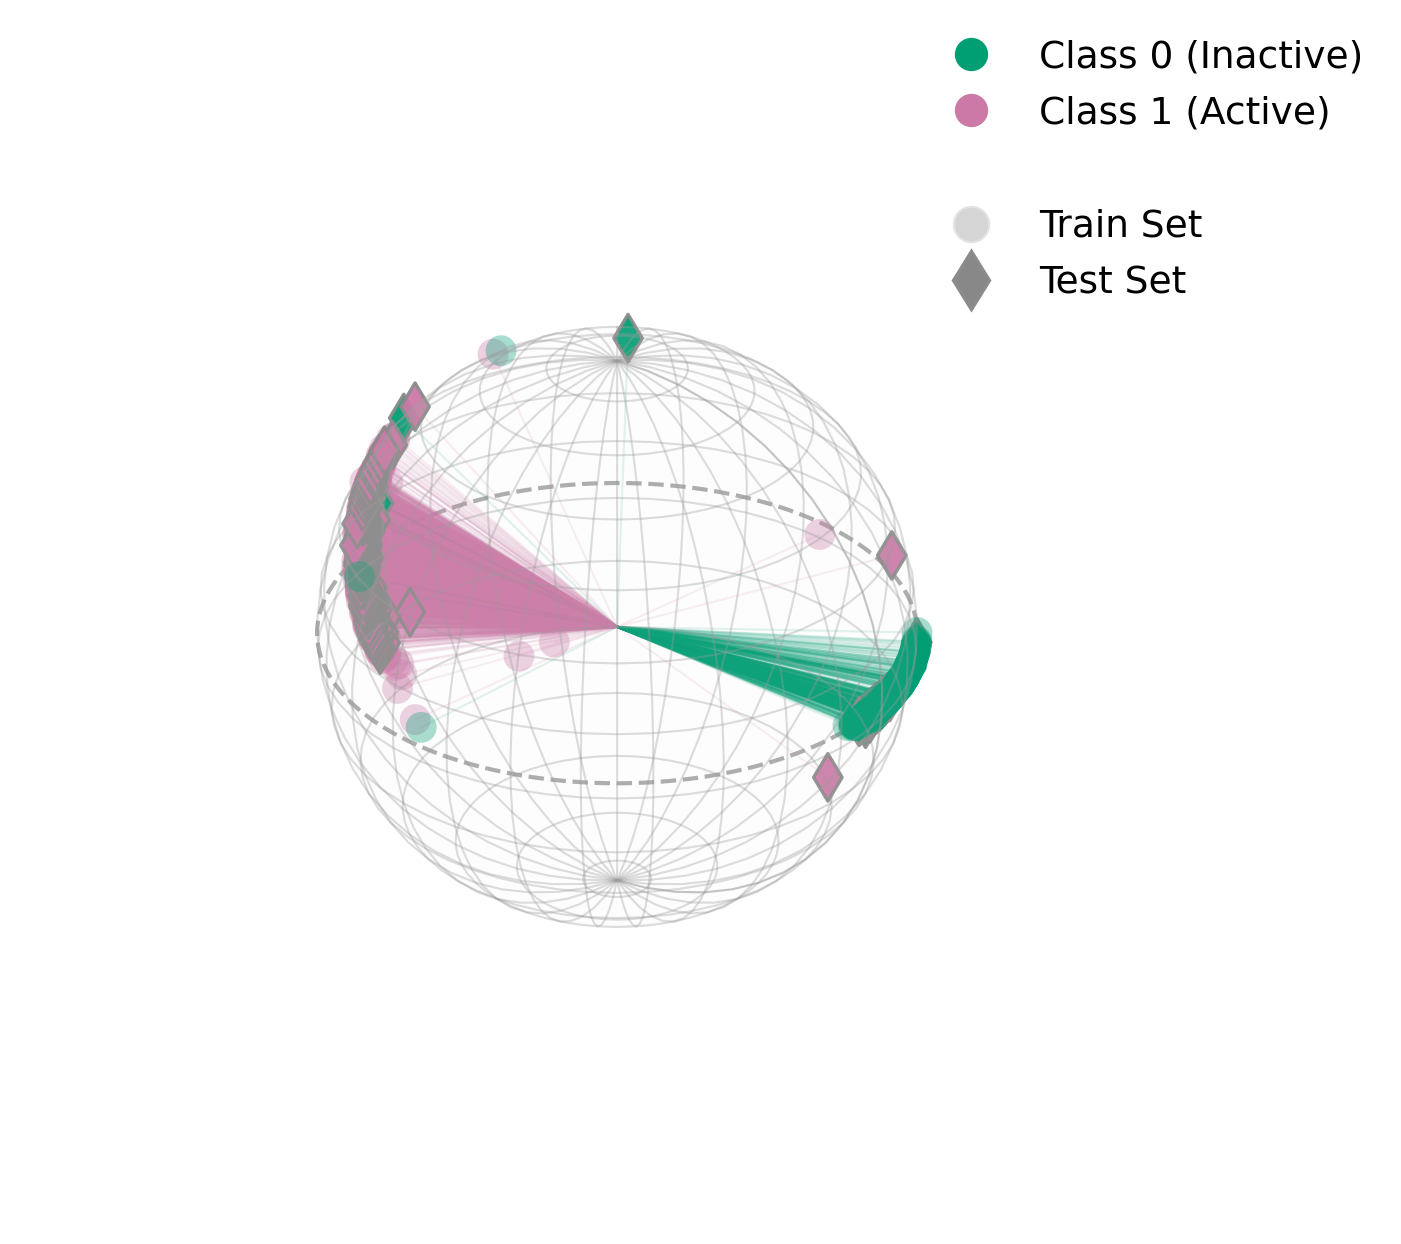

In [15]:
# show smaller in notebook
from IPython.display import Image, display
display(Image(filename=out3d, width=1028))

## Summary

In this notebook, we have:

1) Loaded a trained ArcMol classification model from exported artifacts  
2) Extracted **unit-normalized latent representations Z** for train/test  
3) Reported quantitative clustering metrics on Z  
4) Visualized Z using:
   - t-SNE (2D)
   - spherical map (2D lon/lat)
   - 3D spherical projection

These outputs are provided to help reviewers verify the realism and reproducibility of the learned representations.
